# TikTok Echo Chamber Model

## Background

The TikTok Echo Chamber model seeks to simulate the creation and sustenance of echo chambers on TikTok via bot to bot interactions. It utilizes agent-based modelling to demonstrate how agents - human or bot - of varying political leanings - conservative, progressive or neutral - interact with one another and take-on/lose each other's political leanings, eventually finding themselves surrounded by agents with similar leanings.

The model categorizes interactions like following, sharing, commenting and liking as positive interactions since they promote connection and increase the likelihood of political leanings being adopted. Conversely, interactions like unfollowing and disliking are thus categorized as negative interactions.

Agents are randomly placed on a graph. Human agents start off neutral to reflect a non-tailored For You Page (FYP) when a new user joins TikTok. There is at least one bot agent in the network and bot agents, as in real life, start off with a non-neutral political leaning with the goal of spreading that leaning. Human agents are able to have positive or negative interactions with other agents, while bot agents can only have positive interactions since they aim to spread their leanings. Upon a positive interaction, an agent tries to pass on its leaning to another. Upon a negative interaction, the receiving agent will try to change its political leaning to something other than the initiating agent's.

While individual human agents may interact with others of dissimilar leanings, the amplification of some leaning by bots near the human agent nonetheless leads to clusters of similar leanings.

## Implementation

This is a demonstration of running the TikTok Echo Chamber model in an IPython Notebook. The actual model and agent code are implemented in the src directory of this Github repo. Below, we will import the model class, instantiate it, run it, and plot the time series of the number of happy agents.

Please note that you may have to edit the source code since imports may not be identified in different settings. If the below import fails, make the following changes

In src/app.py change:
<code>from agents import</code> to <code>from src.agents import</code>
<code>from model import</code> to <code>from src.model import</code>

In src/model.py change:
<code>from agents import</code> to <code>from src.agents import</code>

## The following analyses are done in this notebook
[Effect of Number of Bots on Number of Clusters](#s1)
1. [Effect of Number of Bots on Number of Clusters](#Effect-of-Number-of-Bots-on-Number-of-Clusters)
2. [Effect of Probability to Follow on Average Cluster Size](#Effect-of-Probability-to-Follow-on-Average-Cluster-Size)
3. [Comparing Bot-to-Bot Interactions to Echo Chamber Formation Rate](#Comparing-Bot-to-Bot-Interactions-to-Echo-Chamber-Formation-Rate)
4. [Comparing Bot-to-Human Ratio to Echo Chamber Formation Rate](#Comparing-Bot-to-Human-Ratio-to-Echo-Chamber-Formation-Rate)

[References](#references)

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

from src.model import TikTokEchoChamber

Now we instantiate a model instance: 10 nodes with 2 bot nodes and an average node degree of 3. The likelihood of agents to have a positive interaction with others is 40%. After a negative interaction, they have a 50% chance to become neutral.

In [5]:
ttec_model = TikTokEchoChamber(
    num_nodes=10,
    avg_node_degree=3,
    num_cons_bots=1,
    num_prog_bots=1,
    positive_chance=0.4,
    become_neutral_chance=0.5,
    seed=42
)

The model will run until all agents are of non-neutral leaning. However, there's no guarantee that a given model instantiation will *ever* settle down. So it will run for either 100 steps or until it stops on its own, whichever comes first:

In [6]:
while ttec_model.running and ttec_model.steps < 100:
    ttec_model.step()
print(f"Number of Steps {ttec_model.steps}")  # Show how many steps have actually run

Number of Steps 39


In [7]:
from enum import IntEnum
import random
class POSInteraction(IntEnum):
    """Weight of each positive interaction"""
    FOLLOW = 5
    SHARE = 3
    LIKE = 2
    COMMENT = 2
    VIEW = 1

# define list of all positive/negative interaction weights
POSInteraction_LIST = list(map(int,POSInteraction))
class NEGInteraction(IntEnum):
    """Weight of each negative interaction"""
    UNFOLLOW = -5
    DISLIKE = -2


# define list of all positive/negative interaction weights
NEGInteraction_LIST = list(map(int, NEGInteraction))
random.choice(NEGInteraction_LIST)


-2

Generate a pandas DataFrame of the number of conservative, progressive and neutral agent counts at the end of each step.

In [8]:
model_out = ttec_model.datacollector.get_model_vars_dataframe()
model_out.head()

,Conservative,Progressive,Neutral
0,1,1,8
1,3,1,6
2,4,1,5
3,4,1,5
4,5,1,4


Now show the cluster metrics at the end of each step. This is in a specific table of the datacollector.

In [9]:
cluster_out = ttec_model.datacollector.get_table_dataframe("CA")
cluster_out.head()

,Clusters,Num_Clusters,Avg_Cluster_Size,Clstr_Agent_Ratio,Cross_Interactions
0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",10,1.000000,1.0,0
1,"[0, 1, 1, 1, 4, 5, 6, 7, 8, 9]",8,1.250000,0.8,3
2,"[0, 1, 2, 1, 4, 1, 6, 7, 8, 9]",8,1.250000,0.8,6
3,"[0, 1, 2, 1, 4, 1, 6, 7, 8, 9]",8,1.250000,0.8,6
4,"[0, 1, 2, 1, 4, 1, 6, 7, 2, 9]",7,1.428571,0.7,7


Finally, plot both series - political leanings and cluster analysis:

<Axes: >

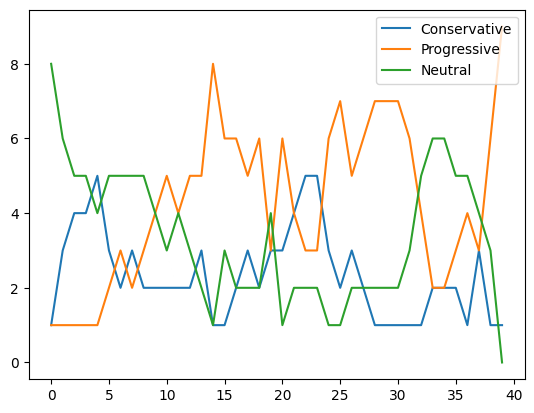

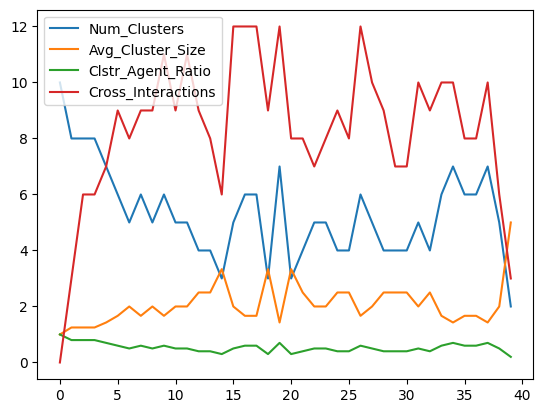

In [10]:
model_out.plot()
cluster_out.plot()

***
# Effect of Number of Bots on Number of Clusters

How big do clusters get when agents are more likely to connect than disconnect?

<a id='s1'></a>

Below we do a parameter sweep to see how the number of clusters changes with the number of bots.

First, we create a function which takes a model instance and returns the number of clusters ie. agents in  proximity to one another which also have similar leanings.

In [11]:
from batchrunner import batch_run

Now, we set up the batch run, with a dictionary of fixed and changing parameters. Let's keep everything fixed except for the Number of Bots. This will be deduced from the sum of Conservative and Progressive bots.

In [12]:
fixed_params = {"num_nodes": 30, "avg_node_degree": 3, "positive_chance": 0.5, "become_neutral_chance": 0.5}
variable_params = {"num_cons_bots": range(1, 9), "num_prog_bots": range(1, 9)}
all_params = fixed_params | variable_params

In [13]:
results = batch_run(
    TikTokEchoChamber,
    parameters=all_params,
    iterations=10,
    max_steps=200,
)

# get dataframe of results
df = pd.DataFrame(results)
df

  0%|          | 0/640 [00:00<?, ?it/s]

,RunId,iteration,Step,num_nodes,avg_node_degree,positive_chance,become_neutral_chance,num_cons_bots,num_prog_bots,Conservative,Progressive,Neutral,CA_Clusters,CA_Num_Clusters,CA_Avg_Cluster_Size,CA_Clstr_Agent_Ratio,CA_Cross_Interactions
0,0,0,200,30,3,0.5,0.5,1,1,22,1,7,"[0, 1, 1, 3, 1, 1, 1, 1, 1, 1, 10, 10, 1, 1, 1...",7,4.285714,0.233333,34
1,1,0,200,30,3,0.5,0.5,1,2,2,25,3,"[0, 1, 0, 0, 4, 0, 0, 0, 1, 0, 0, 11, 0, 13, 1...",6,5.000000,0.200000,28
2,2,0,200,30,3,0.5,0.5,1,3,7,15,8,"[0, 1, 0, 0, 4, 1, 5, 5, 0, 4, 4, 1, 4, 4, 1, ...",7,4.285714,0.233333,36
3,3,0,200,30,3,0.5,0.5,1,4,3,20,7,"[0, 0, 2, 0, 2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8,3.750000,0.266667,36
4,4,0,18,30,3,0.5,0.5,1,5,1,27,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,15.000000,0.066667,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,635,9,40,30,3,0.5,0.5,8,4,21,8,1,"[0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, ...",3,10.000000,0.100000,15
636,636,9,43,30,3,0.5,0.5,8,5,15,12,3,"[0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 12, 1, 14...",6,5.000000,0.200000,30
637,637,9,5,30,3,0.5,0.5,8,6,16,12,2,"[0, 1, 2, 0, 4, 1, 1, 1, 4, 4, 10, 4, 4, 4, 1,...",11,2.727273,0.366667,30
638,638,9,16,30,3,0.5,0.5,8,7,15,14,1,"[0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, ...",3,10.000000,0.100000,27


Plot the Effect of Number of Bots on Number of Clusters

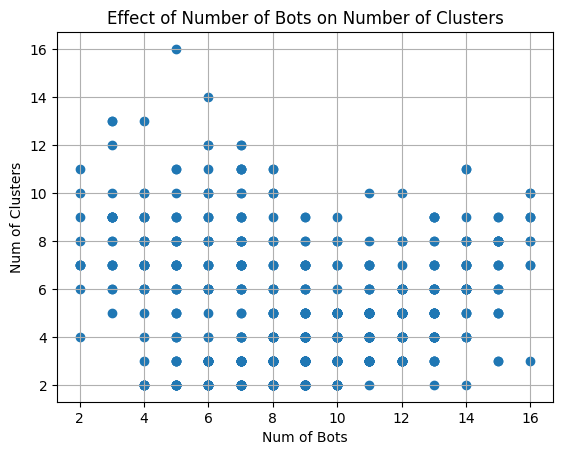

In [14]:
plt.scatter((df.num_cons_bots + df.num_prog_bots), df.CA_Num_Clusters)
plt.xlabel("Num of Bots")
plt.ylabel("Num of Clusters")
plt.grid()
plt.title("Effect of Number of Bots on Number of Clusters")
plt.show()

***
# Effect of Probability to Follow on Average Cluster Size

How big do clusters get when agents are more likely to connect than disconnect?

In [15]:
from numpy import arange

fixed_params2 = {"num_nodes": 20, "avg_node_degree": 3, "num_cons_bots": 2, "num_prog_bots": 2, "become_neutral_chance": 0.5}
variable_params2 = {"positive_chance": arange(0.0, 1.0, 0.1)}
all_params2 = fixed_params2 | variable_params2

results2 = batch_run(
    TikTokEchoChamber,
    parameters=all_params2,
    iterations=10,
    max_steps=200,
)

df2 = pd.DataFrame(results2)
df2

  0%|          | 0/100 [00:00<?, ?it/s]

,RunId,iteration,Step,num_nodes,avg_node_degree,num_cons_bots,num_prog_bots,become_neutral_chance,positive_chance,Conservative,Progressive,Neutral,CA_Clusters,CA_Num_Clusters,CA_Avg_Cluster_Size,CA_Clstr_Agent_Ratio,CA_Cross_Interactions
0,0,0,200,20,3,2,2,0.5,0.0,2,2,16,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",20,1.000000,1.00,0
1,1,0,200,20,3,2,2,0.5,0.1,4,6,10,"[0, 1, 1, 1, 4, 5, 4, 7, 1, 1, 1, 11, 12, 1, 1...",13,1.538462,0.65,24
2,2,0,200,20,3,2,2,0.5,0.2,9,2,9,"[0, 1, 2, 1, 0, 0, 6, 7, 8, 1, 10, 7, 0, 0, 0,...",10,2.000000,0.50,25
3,3,0,200,20,3,2,2,0.5,0.3,4,9,7,"[0, 1, 0, 3, 0, 5, 6, 0, 8, 8, 0, 11, 5, 13, 3...",9,2.222222,0.45,25
4,4,0,75,20,3,2,2,0.5,0.4,11,7,2,"[0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, ...",2,10.000000,0.10,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,9,89,20,3,2,2,0.5,0.5,14,4,2,"[0, 0, 0, 0, 0, 0, 6, 6, 0, 0, 0, 6, 6, 0, 0, ...",2,10.000000,0.10,14
96,96,9,41,20,3,2,2,0.5,0.6,17,2,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 14,...",3,6.666667,0.15,6
97,97,9,9,20,3,2,2,0.5,0.7,2,16,2,"[0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,10.000000,0.10,15
98,98,9,7,20,3,2,2,0.5,0.8,4,15,1,"[0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, ...",2,10.000000,0.10,9


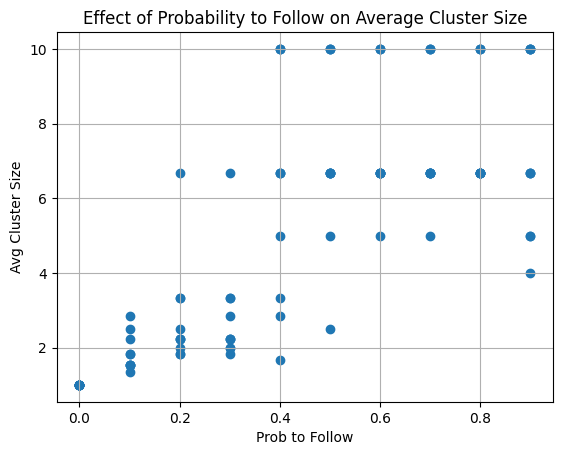

In [16]:
plt.scatter(df2.positive_chance, df2.CA_Avg_Cluster_Size)
plt.xlabel("Prob to Follow")
plt.ylabel("Avg Cluster Size")
plt.grid()
plt.title("Effect of Probability to Follow on Average Cluster Size")
plt.show()

***
# Comparing Bot-to-Bot Interactions to Echo Chamber Formation Rate

How do bot-to-bot interactions influence the number of steps taken to form echo chambers?

In [17]:
fixed_params3 = {"num_nodes": 20, "avg_node_degree": 3, "num_cons_bots": 2, "num_prog_bots": 2, "positive_chance": 0.5, "become_neutral_chance": 0.5}

# TODO when #bot interactions is made, plot that instead
variable_params3 = {"num_cons_bots": range(1, 9), "num_prog_bots": range(1, 9)}
all_params3 = fixed_params3 | variable_params3

results3 = batch_run(
    TikTokEchoChamber,
    parameters=all_params3,
    iterations=10,
    max_steps=200,
)

df3 = pd.DataFrame(results3)
df3

  0%|          | 0/640 [00:00<?, ?it/s]

,RunId,iteration,Step,num_nodes,avg_node_degree,num_cons_bots,num_prog_bots,positive_chance,become_neutral_chance,Conservative,Progressive,Neutral,CA_Clusters,CA_Num_Clusters,CA_Avg_Cluster_Size,CA_Clstr_Agent_Ratio,CA_Cross_Interactions
0,0,0,26,20,3,1,1,0.5,0.5,15,2,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 12, 0...",2,10.000000,0.10,7
1,1,0,87,20,3,1,2,0.5,0.5,2,13,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 0,...",2,10.000000,0.10,3
2,2,0,63,20,3,1,3,0.5,0.5,15,4,1,"[0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 2, ...",3,6.666667,0.15,16
3,3,0,37,20,3,1,4,0.5,0.5,3,15,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0,...",2,10.000000,0.10,3
4,4,0,55,20,3,1,5,0.5,0.5,4,14,2,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,10.000000,0.10,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,635,9,3,20,3,8,4,0.5,0.5,15,4,1,"[0, 1, 2, 2, 1, 5, 6, 2, 8, 9, 10, 0, 12, 9, 2...",10,2.000000,0.50,6
636,636,9,2,20,3,8,5,0.5,0.5,13,6,1,"[0, 0, 0, 0, 4, 5, 2, 0, 0, 9, 2, 11, 2, 2, 14...",10,2.000000,0.50,5
637,637,9,2,20,3,8,6,0.5,0.5,11,7,2,"[0, 1, 2, 1, 2, 5, 2, 7, 2, 9, 2, 2, 12, 13, 1...",11,1.818182,0.55,8
638,638,9,2,20,3,8,7,0.5,0.5,10,9,1,"[0, 1, 2, 1, 4, 5, 1, 7, 8, 1, 10, 0, 12, 1, 1...",11,1.818182,0.55,6


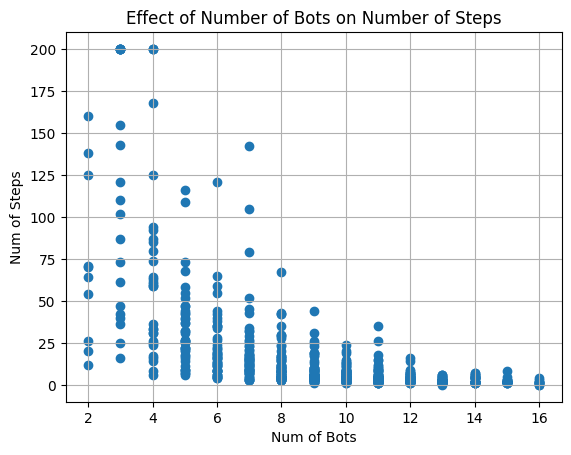

In [18]:
plt.scatter((df3.num_cons_bots + df3.num_prog_bots), df3.Step)
plt.xlabel("Num of Bots")
plt.ylabel("Num of Steps")
plt.grid()
plt.title("Effect of Number of Bots on Number of Steps")
plt.show()

***
# Comparing Bot-to-Human Ratio to Echo Chamber Formation Rate

How do bot-to-bot interactions influence the number of steps taken to form echo chambers?

In [19]:
fixed_params4 = {"num_nodes": 20, "avg_node_degree": 3, "num_cons_bots": 2, "num_prog_bots": 2, "positive_chance": 0.5, "become_neutral_chance": 0.5}

variable_params4 = {"num_cons_bots": range(1, 9), "num_prog_bots": range(1, 9)}
all_params4 = fixed_params4 | variable_params4

results4 = batch_run(
    TikTokEchoChamber,
    parameters=all_params4,
    iterations=10,
    max_steps=200,
)

df4 = pd.DataFrame(results4)
df4

  0%|          | 0/640 [00:00<?, ?it/s]

,RunId,iteration,Step,num_nodes,avg_node_degree,num_cons_bots,num_prog_bots,positive_chance,become_neutral_chance,Conservative,Progressive,Neutral,CA_Clusters,CA_Num_Clusters,CA_Avg_Cluster_Size,CA_Clstr_Agent_Ratio,CA_Cross_Interactions
0,0,0,160,20,3,1,1,0.5,0.5,4,15,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 0,...",2,10.000000,0.10,3
1,1,0,114,20,3,1,2,0.5,0.5,1,17,2,"[0, 1, 0, 3, 0, 3, 0, 0, 0, 3, 0, 3, 0, 0, 0, ...",3,6.666667,0.15,13
2,2,0,84,20,3,1,3,0.5,0.5,2,16,2,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2,10.000000,0.10,1
3,3,0,11,20,3,1,4,0.5,0.5,4,15,1,"[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,10.000000,0.10,3
4,4,0,38,20,3,1,5,0.5,0.5,2,13,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,10.000000,0.10,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,635,9,2,20,3,8,4,0.5,0.5,14,5,1,"[0, 1, 2, 2, 4, 2, 2, 2, 2, 2, 10, 2, 2, 2, 2,...",5,4.000000,0.25,11
636,636,9,1,20,3,8,5,0.5,0.5,10,7,3,"[0, 1, 2, 2, 4, 2, 6, 0, 2, 2, 2, 0, 0, 2, 0, ...",5,4.000000,0.25,8
637,637,9,5,20,3,8,6,0.5,0.5,10,9,1,"[0, 1, 1, 1, 1, 1, 6, 6, 1, 1, 8, 6, 1, 8, 14,...",7,2.857143,0.35,9
638,638,9,1,20,3,8,7,0.5,0.5,9,10,1,"[0, 1, 2, 3, 2, 5, 2, 0, 8, 0, 10, 11, 12, 2, ...",12,1.666667,0.60,6


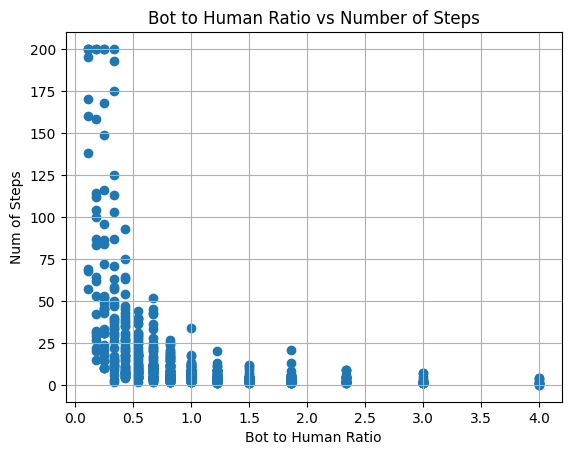

In [20]:
no_bots = (df4.num_cons_bots + df4.num_prog_bots)
no_hums = df4.num_nodes - no_bots
bot_hum_ratio = no_bots.divide(no_hums, fill_value=1)

plt.scatter(bot_hum_ratio, df4.Step)
plt.xlabel("Bot to Human Ratio")
plt.ylabel("Num of Steps")
plt.grid()
plt.title("Bot to Human Ratio vs Number of Steps")
plt.show()

## References

This document was adopted from the Mesa Schelling model analysis file found at the mesa examples repository on GitHub
    [https://github.com/projectmesa/mesa/tree/main/mesa/examples/basic/schelling](https://github.com/projectmesa/mesa/tree/main/mesa/examples/basic/schelling)